# COMP69901 CW 3 - Irrigation Scheduling

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

### Modelling

#### 1. Single Start Irrigation Event Simulation

Let us assume that irrigation only occurs at start in a soil system without external disturbances, where volumetric soil moisture follows exponential decay

\begin{aligned}
\dfrac{d\theta}{dt} &= - \lambda \theta(t), \\
\theta(t) &= \theta_0 e^{-\lambda t}.
\end{aligned}

Further, assume that we have stationary sensor noise when recording volumetric soil moisture

$$
\hat{\theta}(t) = \theta(t) e^\epsilon,\quad \epsilon \sim N(0,\sigma_\theta^2).
$$
We chose this model as it satisfies the constraints of our sensor being noisy, but can only return positive values.

We record observations at regular intervals, and would like to determine $\theta_0$ and $\lambda$.

In [54]:
class SingleStartIrrigationSim:
    def __init__(self, theta0, lam, sigma_theta):
        self.soil_moist = theta0
        self.theta0 = theta0
        self.lam = lam
        self.sigma_theta = sigma_theta
        self.time = 0.0
        self.data = {
            'latent' : {
                't' : [0.0],
                'y' : [theta0]
            },
            'observed' : {
                't' : [],
                'y' : []
            }
        }
    
    def update(self, dt):
        self.time += dt
        self.soil_moist = self.theta0 * np.exp(-self.lam * self.time)
        self.data['latent']['t'].append(self.time)
        self.data['latent']['y'].append(self.soil_moist)

    def observation(self):
        self.data['observed']['t'].append(self.time)
        self.data['observed']['y'].append(self.soil_moist * np.exp(np.random.normal(0, self.sigma_theta)))

In [55]:
theta0 = 50
lam = 0.05
dt = 0.1
obs_interval = 15
t = 60 * 24
sigma_theta = 0.3
min_threshold = sigma_theta

# run simulation
sim = SingleStartIrrigationSim(theta0, lam, sigma_theta)

obs_timer = 0
while (sim.time < t) and (sim.soil_moist > min_threshold or sim.data['observed']['y'][-1] > min_threshold):
    sim.update(dt)
    obs_timer += dt
    if obs_timer >= obs_interval:
        sim.observation()
        obs_timer = 0
sim.data['observed']['t'] = sim.data['observed']['t'][:-1]
sim.data['observed']['y'] = sim.data['observed']['y'][:-1]

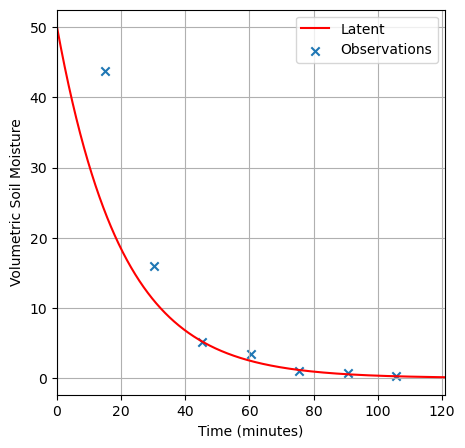

In [5]:
# plot results
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.plot(sim.data['latent']['t'], sim.data['latent']['y'], label='Latent', color='red')  
ax.scatter(sim.data['observed']['t'], sim.data['observed']['y'], marker='x', label='Observations')

ax.grid()

ax.set_xlim(0, sim.time)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Volumetric Soil Moisture')
ax.legend()
plt.show()

In [6]:
ts = np.array(sim.data['observed']['t'])
obs = np.array(sim.data['observed']['y'])
latents = []
for t in ts:
    idx = np.where(sim.data['latent']['t'] == t)[0][0]
    latents.append(sim.data['latent']['y'][idx])
latents = np.array(latents)

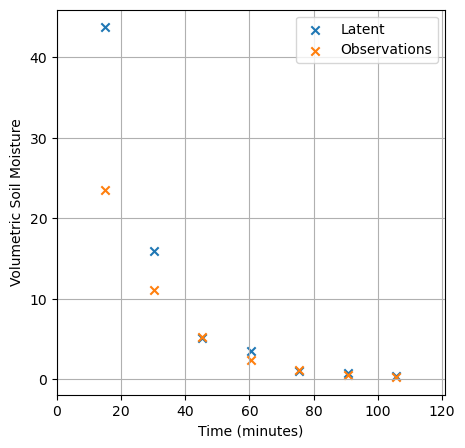

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.scatter(ts, obs, marker='x', label='Latent')  
ax.scatter(ts, latents, marker='x', label='Observations')

ax.grid()

ax.set_xlim(0, sim.time)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Volumetric Soil Moisture')
ax.legend()
plt.show()

Now, assume we would like to estimate $\theta_0$ and $\lambda$

\begin{aligned}
\log \hat{\theta} (t) &= \log \theta(t) e^\epsilon \\
                      &= \log \theta(t) + \epsilon \\
                      &= - \lambda t + \log \theta_0 + \epsilon \equiv (a t + b) + \epsilon_t
\end{aligned}

Thus, we can learn $\theta_0$ and $\lambda$ from bayesian linear regression on $\log \hat{\theta}(t)$.

In [8]:
# TODO bayesian linear regression

import numpy as np

def linear_regression(ts, obs):
    """
    Linear regression for time and observations, estimate theta_0 and lambda
    using the formula log(obs(t)) = - lambda *t + log(theta_0) + eps; eps is gaussian noise
    """
    # Convert observations to log scale
    log_obs = np.log(obs)
    
    # Prepare the design matrix for linear regression
    X = np.vstack((np.ones_like(ts), -ts)).T
    
    # Perform linear regression using the normal equation
    # theta = (X^T * X)^(-1) * X^T * y
    theta = np.linalg.inv(X.T @ X) @ X.T @ log_obs
    
    # Extract parameters
    log_theta_0 = theta[0]
    lambda_ = theta[1]
    
    # Convert log_theta_0 to theta_0
    theta_0 = np.exp(log_theta_0)
    
    return theta_0, lambda_

theta_0, lambda_ = linear_regression(ts, obs)

print(f"The parameters recovered are theta_0 = {theta_0} and lambda = {lambda_}.")
print(f'The actual parameters are theta_0 = {theta0} and lambda = {lam}.')

The parameters recovered are theta_0 = 75.31929769540223 and lambda = 0.05236557611698309.
The actual parameters are theta_0 = 50 and lambda = 0.05.


#### 2. Regular Irrigation Event Simulation

I have not actually figured any of this out other than guessing, but I will use this equation

\begin{aligned}
\theta(t) &= \theta_{0} \sum_{i} e^{-\lambda (t-t_i)} \delta(t - t_i).
\end{aligned}


Further, assume that we have stationary sensor noise when recording volumetric soil moisture

$$
\hat{\theta}(t) = \theta(t) e^\epsilon,\quad \epsilon \sim N(0,\sigma_\theta^2).
$$

In [9]:
class RegularIrrigationSim:
    def __init__(self, theta0, starts, lam, sigma_theta):
        self.soil_moist = theta0 * np.dot(np.ones_like(starts), 0 >= starts)
        self.theta0 = theta0
        self.lam = lam
        self.sigma_theta = sigma_theta
        self.time = 0.0
        self.starts = starts
        self.data = {
            'latent' : {
                't' : [0.0],
                'y' : [self.soil_moist]
            },
            'observed' : {
                't' : [],
                'y' : []
            }
        }
    
    def update(self, dt):
        self.soil_moist = self.theta0 * np.dot(np.exp(-self.lam * (self.time - self.starts)), self.time >= self.starts)
        self.time += dt
        self.data['latent']['t'].append(self.time)
        self.data['latent']['y'].append(self.soil_moist)

    def observation(self):
        self.data['observed']['t'].append(self.time)
        self.data['observed']['y'].append(self.soil_moist * np.exp(np.random.normal(0, self.sigma_theta)))

In [10]:
theta0 = 50
starts = np.array([0, 100, 200])
lam = 0.05
dt = 0.1
obs_interval = 15
t = 60 * 24
sigma_theta = 0.3
min_threshold = sigma_theta

# run simulation
sim = RegularIrrigationSim(theta0, starts, lam, sigma_theta)

obs_timer = 0
while (sim.time < t) and (sim.soil_moist > min_threshold):
    sim.update(dt)
    obs_timer += dt
    if obs_timer >= obs_interval:
        sim.observation()
        obs_timer = 0
sim.data['observed']['t'] = sim.data['observed']['t'][:-1]
sim.data['observed']['y'] = sim.data['observed']['y'][:-1]

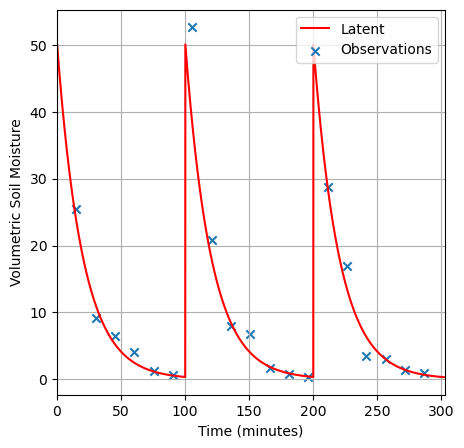

In [11]:
# plot results
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.plot(sim.data['latent']['t'], sim.data['latent']['y'], label='Latent', color='red')  
ax.scatter(sim.data['observed']['t'], sim.data['observed']['y'], marker='x', label='Observations')

ax.grid()

ax.set_xlim(0, sim.time)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Volumetric Soil Moisture')
ax.legend()
plt.show()

Now, assume we would like to estimate $\theta_0$ and $\lambda$

\begin{aligned}
\log \hat{\theta} (t) &= \log \theta(t) e^\epsilon \\
                      &= \log \theta(t) + \epsilon \\
                      &= \log \sum_{t \geq t_i} e^{- \lambda (t-t_i)} + \log \theta_0 + \epsilon \\
                      &\approx - \lambda (t-t_i^*) + \log \theta_0 + \epsilon
\end{aligned}
where $t_i^* = \max_{t_i \in \{t_i \mid t \geq t_i \}} t_i$

Thus, we can learn $\theta_0$ and $\lambda$ from bayesian linear regression on $\log \hat{\theta}(t)$, if we can seperate data points by which irrigation cycle they are in, which as we are the irrigators, we know exactly when this is :)

In [12]:
### TODO Bayesian Linear Regression with change correction

#### 3. Regular Variable Irrigation Event Simulation



\begin{aligned}
\theta(t) &= \sum_{i} \theta_i e^{-\lambda (t-t_i)} \delta(t - t_i).
\end{aligned}


Further, assume that we have stationary sensor noise when recording volumetric soil moisture

$$
\hat{\theta}(t) = \theta(t) e^\epsilon,\quad \epsilon \sim N(0,\sigma_\theta^2).
$$

In [13]:
class RegularVariableIrrigationSim:
    def __init__(self, theta0, starts, lam, sigma_theta):
        self.soil_moist = np.dot(theta0, 0 >= starts)
        self.theta0 = theta0
        self.lam = lam
        self.sigma_theta = sigma_theta
        self.time = 0.0
        self.starts = starts
        self.data = {
            'latent' : {
                't' : [0.0],
                'y' : [self.soil_moist]
            },
            'observed' : {
                't' : [],
                'y' : []
            }
        }
    
    def update(self, dt):
        self.soil_moist = np.dot(self.theta0 * np.exp(-self.lam * (self.time - self.starts)), self.time >= self.starts)
        self.time += dt
        self.data['latent']['t'].append(self.time)
        self.data['latent']['y'].append(self.soil_moist)

    def observation(self):
        self.data['observed']['t'].append(self.time)
        self.data['observed']['y'].append(self.soil_moist * np.exp(np.random.normal(0, self.sigma_theta)))

In [14]:
theta0 = np.array([50, 40, 60])
starts = np.array([0, 100, 175])
lam = 0.05
dt = 0.1
obs_interval = 15
t = 60 * 24
sigma_theta = 0.3
min_threshold = sigma_theta

# run simulation
sim = RegularVariableIrrigationSim(theta0, starts, lam, sigma_theta)
obs_timer = 0
while (sim.time < t) and (sim.soil_moist > min_threshold):
    sim.update(dt)
    obs_timer += dt
    if obs_timer >= obs_interval:
        sim.observation()
        obs_timer = 0
sim.data['observed']['t'] = sim.data['observed']['t'][:-1]
sim.data['observed']['y'] = sim.data['observed']['y'][:-1]

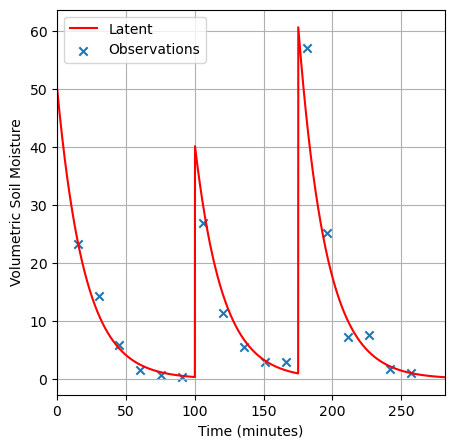

In [15]:
# plot results
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.plot(sim.data['latent']['t'], sim.data['latent']['y'], label='Latent', color='red')  
ax.scatter(sim.data['observed']['t'], sim.data['observed']['y'], marker='x', label='Observations')

ax.grid()

ax.set_xlim(0, sim.time)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Volumetric Soil Moisture')
ax.legend()
plt.show()

Now, assume we would like to estimate $\theta_i$ and $\lambda$

\begin{aligned}
\log \hat{\theta} (t) &= \log \theta(t) e^\epsilon \\
                      &= \log \theta(t) + \epsilon \\
                      &= \log \sum_{t \geq t_i} \theta_i e^{- \lambda (t-t_i)} + \epsilon \\
                      &\approx - \lambda (t-t_i^*) + \log \theta_i^* + \epsilon
\end{aligned}
where $t_i^* = \max_{t_i \in \{t_i \mid t \geq t_i \}} t_i$

Thus, we can learn $\theta_i$ and $\lambda$ from bayesian linear regression on $\log \hat{\theta}(t)$, if we can seperate data points by which irrigation cycle they are in, which as we are the irrigators, we know exactly when this is :)

In [16]:
### TODO Bayesian Linear regression

#### 4. Regular Variable Irrigation with Bias Event Simulation (You can simulate this, but parameter estimation becomes problematic)


\begin{aligned}
\theta(t) &= \sum_{i} (\theta_i e^{-\lambda (t-t_i)} + \beta_i ) \delta(t - t_i) \delta(t_{i+1} - t).
\end{aligned}


Further, assume that we have stationary sensor noise when recording volumetric soil moisture

$$
\hat{\theta}(t) =  \sum_{i} (\theta_i e^{-\lambda (t-t_i)} e^\epsilon  + \beta_i) \delta(t - t_i) \delta(t_{i+1} - t) ,\quad \epsilon \sim N(0,\sigma_\theta^2).
$$


\begin{aligned}
\log \left(\hat{\theta} (t) - \sum_i \beta_i \delta(t - t_i)\right) &= \log \left(\sum_{i} (\theta_i e^{-\lambda (t-t_i)} + \beta_i) \delta(t - t_i) \right) \\
                      &= \log \left(\theta_i e^{- \lambda (t-t_i)+\epsilon}  +\beta_i \right)\\
                      &= \log \left(\frac{\theta_i}{\beta_i} e^{- \lambda (t-t_i) + \epsilon} + 1 \right) + \log{\beta_i} \\
\end{aligned}

for $t>>\lambda, \theta(t) \approx \beta_i$

Remove $\beta_i$ like this, then do as before, i.e., when delta t is less than certain amount, take mean of values / just take final value to be $\beta_i$

In [17]:
class RegularVariableIrrigationSim:
    def __init__(self, theta0, starts, lam, betas, sigma_theta):
        self.soil_moist = np.dot(theta0 + betas, 0 >= starts)
        self.theta0 = theta0
        self.lam = lam
        self.betas = betas
        self.sigma_theta = sigma_theta
        self.time = 0.0
        self.starts = starts
        self.data = {
            'latent' : {
                't' : [0.0],
                'y' : [self.soil_moist]
            },
            'observed' : {
                't' : [],
                'y' : []
            }
        }
    
    def update(self, dt):
        self.soil_moist = np.dot(self.theta0 * np.exp(-self.lam * (self.time - self.starts)) + self.betas, self.time >= self.starts)
        self.time += dt
        self.data['latent']['t'].append(self.time)
        self.data['latent']['y'].append(self.soil_moist)

    def observation(self):
        self.data['observed']['t'].append(self.time)
        self.data['observed']['y'].append(self.soil_moist * np.exp(np.random.normal(0, self.sigma_theta)))

In [18]:
theta0 = np.array([50, 40, 60])
starts = np.array([0, 100, 175])
lam = 0.05
betas = np.array([0, 10, 20])
dt = 0.1
obs_interval = 15
t = 60 * 24
sigma_theta = 0.3
min_threshold = sigma_theta

# run simulation
sim = RegularVariableIrrigationSim(theta0, starts, lam, betas, sigma_theta)
obs_timer = 0
while (sim.time < t) and (sim.soil_moist > min_threshold):
    sim.update(dt)
    obs_timer += dt
    if obs_timer >= obs_interval:
        sim.observation()
        obs_timer = 0
sim.data['observed']['t'] = sim.data['observed']['t'][:-1]
sim.data['observed']['y'] = sim.data['observed']['y'][:-1]

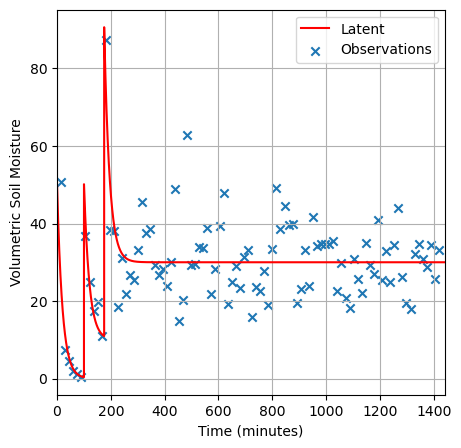

In [19]:
# plot results
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.plot(sim.data['latent']['t'], sim.data['latent']['y'], label='Latent', color='red')  
ax.scatter(sim.data['observed']['t'], sim.data['observed']['y'], marker='x', label='Observations')

ax.grid()

ax.set_xlim(0, sim.time)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Volumetric Soil Moisture')
ax.legend()
plt.show()

We are stuck with this model :( Because of how we define our error, it behaves very strangely

Follow up ideas:

- Treat as periodic gaussian process (use irrigation interval) - use exponential kernel
- Treat as periodic orhnstein-uhlembeck process - (multiply uhlembeck ornhstein kernel by periodic kernel)
- Use schroeder's backward integration method to determine decay rate (assumes additive noise) - Xiang propose a bayesian approach to this in a paper, yet to look to deeply at it - but we could do it with bayesian quadrature?

Now lets try this on the real-world data!

## Load dataset and split

In [20]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# from IPython.display import display, Math, Latex

In [21]:
#Bring in Data
df_raw = pd.read_csv('RainGarden.csv')
df_raw.shape

(14889, 4)

In [ ]:
# NOTE why the author only loads this portion of data?
df_f = df_raw.iloc[7000:10000]
df_f.head()

,Time,wfv_1,wfv_2,wfv_3
7000,6/4/22 8:45,23.476951,20.388335,20.142405
7001,6/4/22 9:00,23.476951,20.302906,20.142405
7002,6/4/22 9:15,23.367694,20.106473,20.142405
7003,6/4/22 9:30,23.636009,20.106473,20.142405
7004,6/4/22 9:45,23.364815,20.018843,20.140844


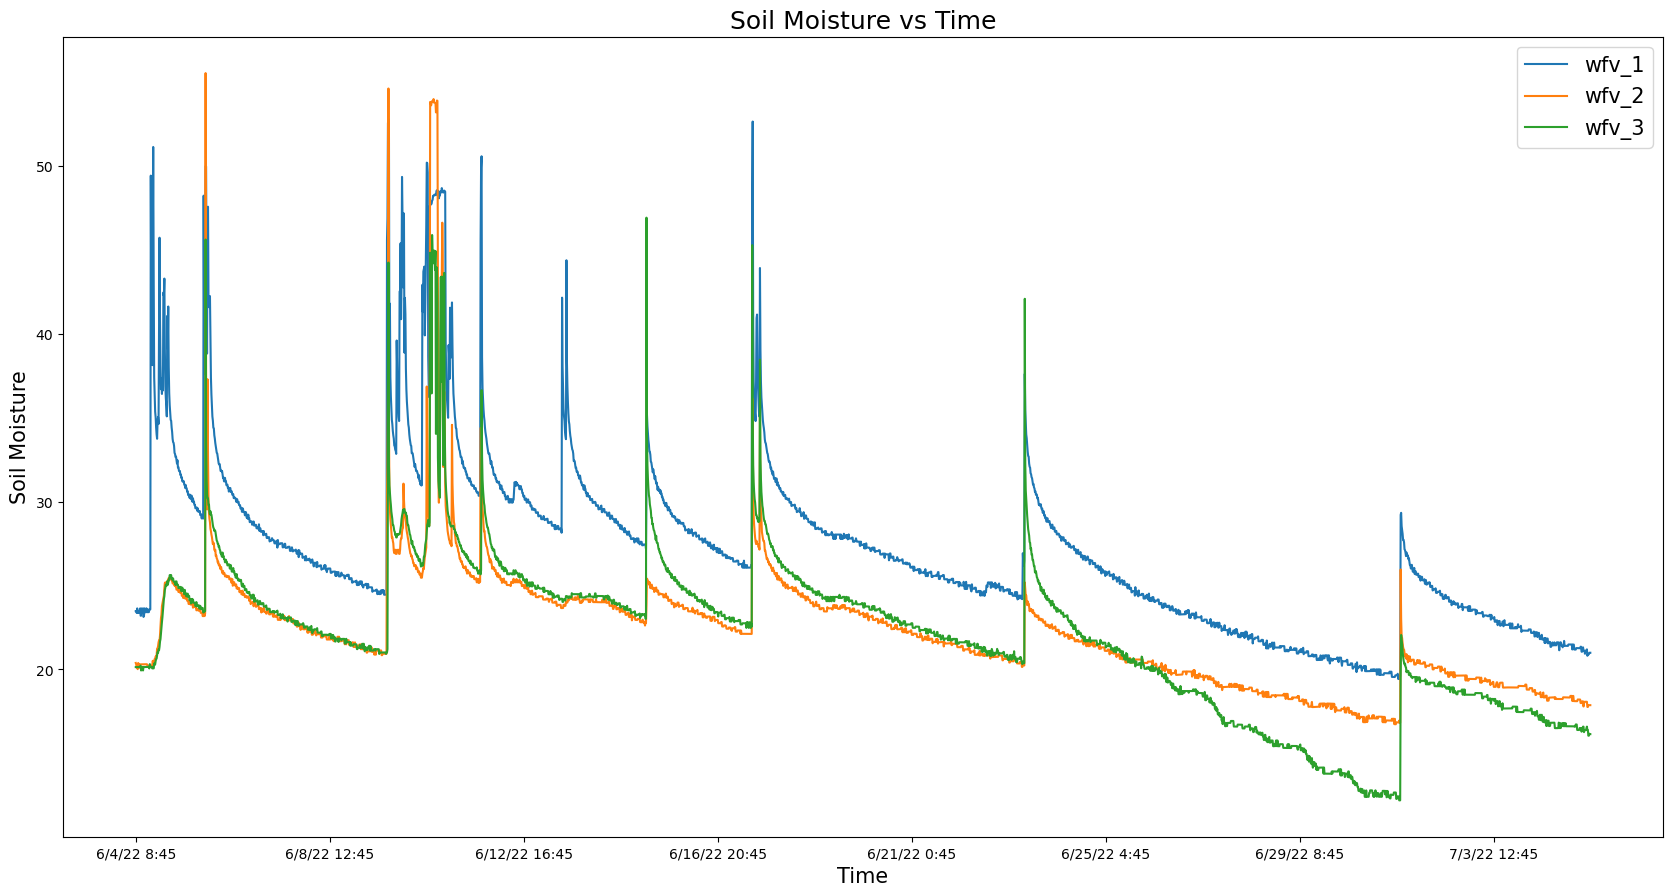

In [23]:
#Plot Data. 
#Each soil sensor is measuring percent moisture at 16 cm below surface. 
x = df_f['Time']
y_1 = df_f['wfv_1']
y_2 = df_f['wfv_2']
y_3 = df_f['wfv_3']

fig = plt.figure(figsize=(16,8))
axes_4 = fig.add_axes([0,0,1,1]) #this means you want the whole array
axes_4.set_xlabel('Time' ,fontsize=15,) 
axes_4.set_ylabel('Soil Moisture',fontsize=15)
axes_4.set_title('Soil Moisture vs Time',fontsize=18)
axes_4.plot(x, y_1, label='wfv_1')
axes_4.plot(x, y_2, label='wfv_2')
axes_4.plot(x, y_3, label='wfv_3')
axes_4.legend(loc='best',fontsize=15)


plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))

plt.show()

In [24]:
def split_series_to_arrays(y: pd.Series):
    """Splits a pandas Series into a list of NumPy arrays based on differences > 10.

    Args:
        y: The pandas Series to split.

    Returns:
        A list of NumPy arrays. Returns a list containing the Series as a NumPy
        array if no splits are found. Raises TypeError if input is not a Series.
    """

    if not isinstance(y, pd.Series):
        raise TypeError("Input must be a pandas Series.")

    if len(y) <= 1:
        return [y.values] #convert to numpy array

    diff = y.diff()
    print(diff)
    ind = np.where(diff > 10)[0]
    print(ind)

    if not ind.size:
        return [y.values] #convert to numpy array

    split_arrays = []
    start = 0
    for i in ind:
        split_arrays.append(y.iloc[start : i + 1].values) #convert to numpy array
        start = i + 1

    if start < len(y):
        split_arrays.append(y.iloc[start:].values) #convert to numpy array

    return split_arrays, ind

ys, split_pts = split_series_to_arrays(y_1)

7000         NaN
7001    0.000000
7002   -0.109258
7003    0.268315
7004   -0.271194
          ...   
9995    0.000000
9996    0.000000
9997    0.090213
9998   -0.001527
9999    0.001527
Name: wfv_1, Length: 3000, dtype: float64
[  31  140  518  591  606  711  879  888 1271 1833]


/var/folders/75/bxpz0dmj2f54jdmkxsc585340000gp/T/ipykernel_23618/4234948158.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return smoothed_y.fillna(method='bfill').fillna(method='ffill') #fill nan values


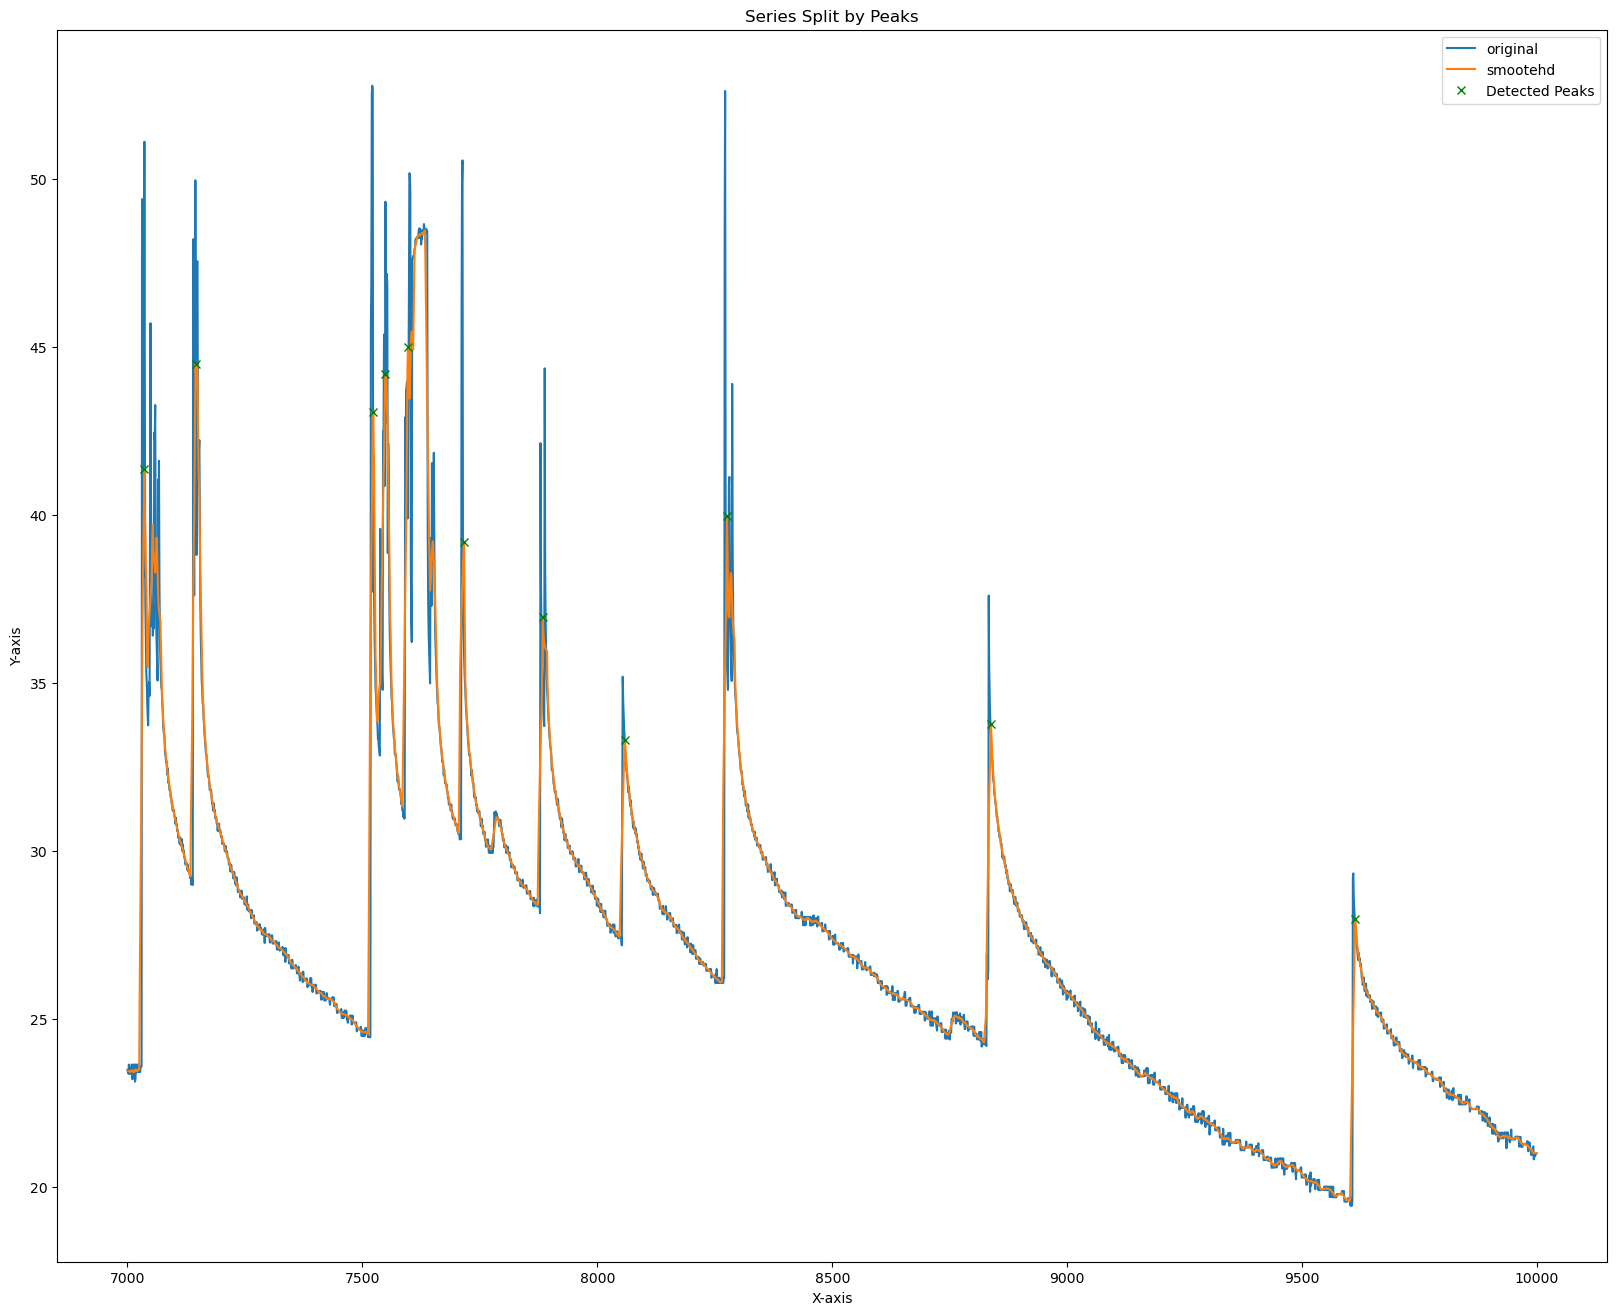

Split Arrays:
[23.44008233 23.44008233 23.44008233 23.44008233 23.44008233 23.44008233
 23.41507015 23.42952991 23.44780635 23.44169052 23.46647454 23.43488587
 23.42033071 23.44524475 23.43910516 23.41837529 23.45199185 23.49198382
 23.47138469 23.45716284 23.45768372 23.43721603 23.46318802 23.49693244
 23.49120768 23.50660301 25.87014558 27.47178773 29.23506025 30.57248791
 32.54775847 35.05130198 36.84826761 38.11981178 39.27290747 40.34293952]
[41.38364458 40.01954292 39.36546096 38.52000465 38.22045162 37.30088926
 35.80102433 35.47632152 36.23176802 36.64903516 36.90293492 37.05393107
 37.3006114  37.51988102 37.84682364 38.00957896 38.68430135 39.37901181
 39.71254936 39.10227236 38.74102441 38.56230466 38.47305442 38.28721538
 38.7097669  38.87019334 39.32447093 38.9225231  38.39408337 37.70845652
 37.36890432 37.18590848 37.06190004 36.94370116 36.8596741  36.19364767
 35.68825564 34.95026933 34.52149831 34.19892839 33.93523871 33.6977946
 33.49900039 33.28629013 33.0915996  

In [ ]:
import pandas as pd
import numpy as np

# TODO might be better if first split by peaks and then smooth?

def smooth_series(y: pd.Series, k: int):
    """Smooths a pandas Series using a moving average.

    Args:
        y: The pandas Series.
        k: The window size for the moving average (number of points on each side).

    Returns:
        A smoothed pandas Series.
        Returns the original series if k is invalid
    Raises TypeError if input is not a Series.
    Raises ValueError if k is not positive.
    """
    if not isinstance(y, pd.Series):
        raise TypeError("Input must be a pandas Series.")
    if k <= 0:
        raise ValueError("k must be positive")
    if k >= len(y):
        print("k is bigger than the length of the series. returning the original series")
        return y

    window_size = 2 * k + 1  # Total window size
    smoothed_y = y.rolling(window=window_size, center=True).mean()
    return smoothed_y.fillna(method='bfill').fillna(method='ffill') #fill nan values


def split_series_by_peaks(y: pd.Series, threshold: float = 10.0):
    """Splits a pandas Series into a list of NumPy arrays based on detected peaks.

    A peak is defined as a value that:
    1. Is greater than both its preceding and succeeding values.
    2. The cumulative increment leading up to the peak exceeds a threshold.

    Args:
        y: The pandas Series to split.
        threshold: The cumulative increment threshold for peak detection.

    Returns:
        A tuple containing:
            - A list of NumPy arrays (the split segments).
            - A NumPy array of peak indices.
        Returns a list containing the Series as a NumPy array and an empty array if no splits are found.
        Raises TypeError if input is not a Series.
        Raises ValueError if threshold is not positive
    """
    if not isinstance(y, pd.Series):
        raise TypeError("Input must be a pandas Series.")
    if threshold <= 0:
        raise ValueError("Threshold must be positive")
    if len(y) <= 2:  # Need at least 3 points to check for peaks
        return [y.values], np.array([])

    peaks = []
    cumulative_increment = 0
    for i in range(1, len(y) - 1):
        if (y.iloc[i] > y.iloc[i - 1]) and (y.iloc[i] > y.iloc[i + 1]):
            # Check for the cumulative increase leading to the peak
            cumulative_increment = 0
            j = i
            while j > 0 and y.iloc[j] > y.iloc[j-1]:
                cumulative_increment += y.iloc[j] - y.iloc[j - 1]
                j -= 1

            if cumulative_increment >= threshold:
                peaks.append(i)

    if not peaks:
        return [y.values], np.array([])

    split_arrays = []
    start = 0
    for peak_index in peaks:
        split_arrays.append(y.iloc[start : peak_index].values)
        start = peak_index

    if start < len(y):
        split_arrays.append(y.iloc[start:].values)

    return split_arrays, np.array(peaks)

y_series = pd.Series(y_1)
y_smooth = smooth_series(y_series, k=5)

plt.figure(figsize=(20, 16))
plt.plot(y_series, label="original")
plt.plot(y_smooth, label="smootehd")
split_arrays, peak_indices = split_series_by_peaks(y_smooth, threshold=5)

plt.plot(peak_indices + 7000, y_smooth.iloc[peak_indices], "x", color="green", label="Detected Peaks")  # Mark peaks
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Moisture Split by Peaks")

#Plot vertical lines to show the splits
# for index in peak_indices:
#     plt.axvline(x=index + 7000, color='r', linestyle='--', linewidth=0.8)

plt.legend()
plt.show()

print("Split Arrays:")
for arr in split_arrays:
    print(arr)
print("Peak Indices:", peak_indices)

In [48]:
split_times = []

for y in split_arrays:
    split_times.append(np.arange(len(y)) * 15)

In [ ]:
# TODO test on the last segments of the data, underfit
idx = -2
ts = split_times[idx]
obs = split_arrays[idx]

theta0, lam = linear_regression(ts, obs)

print(f"The parameters recovered are theta0 = {theta_0} and lambda = {lam}.")

dt = 0.1 # what is dt? noise??
obs_interval = 15
t = ts[-1]
sigma_theta = 0.3 # what is this??
min_threshold = sigma_theta

# run simulation
sim = SingleStartIrrigationSim(theta0, lam, sigma_theta)

obs_timer = 0
while (sim.time < t) and (sim.soil_moist > min_threshold or sim.data['observed']['y'][-1] > min_threshold):
    sim.update(dt)
    obs_timer += dt
    if obs_timer >= obs_interval:
        sim.observation()
        obs_timer = 0
sim.data['observed']['t'] = sim.data['observed']['t'][:-1]
sim.data['observed']['y'] = sim.data['observed']['y'][:-1]

The parameters recovered are theta0 = 25.825510694187397 and lambda = 3.4159504116866215e-05.


767 775


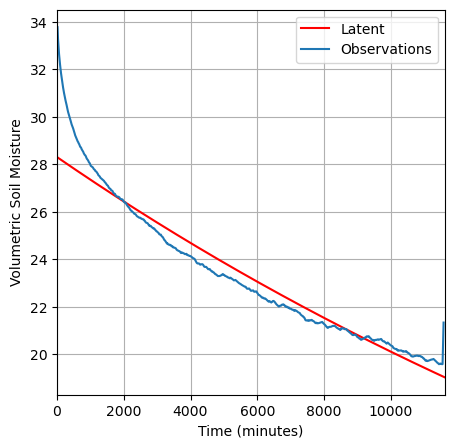

In [64]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.plot(sim.data['latent']['t'], sim.data['latent']['y'], label='Latent', color='red')  
# ax.scatter(sim.data['observed']['t'], sim.data['observed']['y'], marker='x', label='Observations')
print(len(sim.data['observed']['t']), len(obs))
ax.plot(sim.data['observed']['t'], obs[:len(sim.data['observed']['t'])], label="Observations")
ax.grid()

ax.set_xlim(0, sim.time)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Volumetric Soil Moisture')
ax.legend()
plt.show()